Aris

> Link Dataset : https://www.kaggle.com/lokkagle/movie-genre-data

Library

In [18]:

# u/ dataframe
import pandas as pd
import re


# u/ split data
from sklearn.model_selection import train_test_split

# u/ preprocessing dan layer
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM,Dense,Embedding,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# u/ visualisasi plot
import matplotlib.pyplot as plt

Read Dataset

In [19]:
df = pd.read_csv("kaggle_movie_train.csv")
df.head()

,id,text,genre
0,0,"eady dead, maybe even wishing he was. INT. 2ND...",thriller
1,2,"t, summa cum laude and all. And I'm about to l...",comedy
2,3,"up Come, I have a surprise.... She takes him ...",drama
3,4,ded by the two detectives. INT. JEFF'S APARTME...,thriller
4,5,"nd dismounts, just as the other children reach...",drama


Mengecek jumlah value tiap genre

In [20]:
df['genre'].value_counts()

drama        8873
thriller     6824
comedy       2941
action       2392
sci-fi        613
horror        456
other         270
adventure     147
romance        63
Name: genre, dtype: int64

Kesempatan kali ini akan menggunakan 4 genre saja yaitu comedy action sci-fi dan horror

In [22]:
# Menghapus genre selain 4 genre tersebut
df = df[~df['genre'].isin(['drama','thriller','adventure','romance'])]
df['genre'].value_counts()

comedy    2941
action    2392
sci-fi     613
horror     456
other      270
Name: genre, dtype: int64

Preprocessing kolom text 

In [7]:
# Menghapus special character di kolom text
df['Text'] = df['text'].map(lambda x: re.sub(r'\W+', ' ', x))
# drop kolom id dan text lama
df = df.drop(['id', 'text'], axis=1)
df.head()

,genre,Text
1,comedy,t summa cum laude and all And I m about to lau...
9,action,e reels as the world spins Sweat pours off him...
20,comedy,I say he s a man who ll go far Some people sa...
25,comedy,you find out where the bachelor party is COLE ...
29,comedy,ibly horrendous public break up on the quad Ag...


Pengecekan nilai kosong

In [23]:
# Mengecek nilai kosong 
havenull=df.isnull().values.any()
if havenull:
    print("data have null value")
else:
     print("data clean" )   

data clean


Pelabelan genre

In [24]:
genre = pd.get_dummies(df.genre)
df_genre = pd.concat([df, genre], axis=1)
df_genre = df_genre.drop(columns='genre')
df_genre.head()

,id,text,action,comedy,horror,other,sci-fi
1,2,"t, summa cum laude and all. And I'm about to l...",0,1,0,0,0
9,11,e reels as the world spins. Sweat pours off hi...,1,0,0,0,0
20,23,I say he's a man who'll go far. Some people s...,0,1,0,0,0
25,29,you find out where the bachelor party is? COLE...,0,1,0,0,0
29,33,ibly horrendous public break up on the quad. A...,0,1,0,0,0


Mengubah tipe data

In [10]:
# Mengubah tipe data menjadi str dan numpy array 
text = df_genre['Text'].astype(str)
label = df_genre[['action', 'comedy','horror','sci-fi']].values

Split dataset 20% test / validasi

In [11]:
genre_train, genre_test, label_train, label_test = train_test_split(text, label, test_size = 0.2)

Penggunaan tokenizer

In [12]:
# mengkonversikan ke sequence
tokenizer = Tokenizer(num_words=5000, oov_token='x')
tokenizer.fit_on_texts(genre_train) 
tokenizer.fit_on_texts(genre_test)
 
sekuens_train = tokenizer.texts_to_sequences(genre_train)
sekuens_test = tokenizer.texts_to_sequences(genre_test)
 
padded_train = pad_sequences(sekuens_train) 
padded_test = pad_sequences(sekuens_test)

Pemodelan Sequential dengan Embedding dan LSTM

In [13]:
model = Sequential([
    Embedding(input_dim=5000, output_dim=16),
    LSTM(64),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

2022-11-29 05:53:38.748212: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-29 05:53:38.749693: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-29 05:53:38.750301: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-11-29 05:53:38.750528: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-11-29 05:53:38.750701: W tensorflow/c

Model compiile dengan optimizer Adam

In [14]:
Adam(learning_rate=0.00146, name='Adam')
model.compile(optimizer = 'Adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])

Penggunaan callback u/ accuracy dan val diatas 90%

In [15]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.9 and logs.get('val_accuracy')>0.9):
      print("\nAkurasi train dan validasi didapat telah mencapai nilai > 90%!")
      self.model.stop_training = True
callbacks = myCallback()

Melatih model

In [16]:
num_epochs = 30
history = model.fit(padded_train, label_train, epochs=num_epochs, validation_data=(padded_test, label_test), verbose=2, callbacks=[callbacks])

Epoch 1/30
161/161 - 24s - loss: 1.1758 - accuracy: 0.4398 - val_loss: 1.1100 - val_accuracy: 0.4668 - 24s/epoch - 147ms/step
Epoch 2/30
161/161 - 19s - loss: 0.9472 - accuracy: 0.5026 - val_loss: 0.8195 - val_accuracy: 0.5847 - 19s/epoch - 121ms/step
Epoch 3/30
161/161 - 21s - loss: 0.7396 - accuracy: 0.6061 - val_loss: 0.8204 - val_accuracy: 0.5706 - 21s/epoch - 128ms/step
Epoch 4/30
161/161 - 20s - loss: 0.5876 - accuracy: 0.7383 - val_loss: 0.7942 - val_accuracy: 0.6870 - 20s/epoch - 125ms/step
Epoch 5/30
161/161 - 19s - loss: 0.4395 - accuracy: 0.8371 - val_loss: 0.5242 - val_accuracy: 0.8220 - 19s/epoch - 119ms/step
Epoch 6/30
161/161 - 21s - loss: 0.3639 - accuracy: 0.8549 - val_loss: 0.5512 - val_accuracy: 0.8384 - 21s/epoch - 130ms/step
Epoch 7/30
161/161 - 20s - loss: 0.2222 - accuracy: 0.9020 - val_loss: 0.4439 - val_accuracy: 0.8579 - 20s/epoch - 122ms/step
Epoch 8/30
161/161 - 21s - loss: 0.1714 - accuracy: 0.9190 - val_loss: 0.4685 - val_accuracy: 0.8634 - 21s/epoch - 129

Membuat plot accuracy dan loss

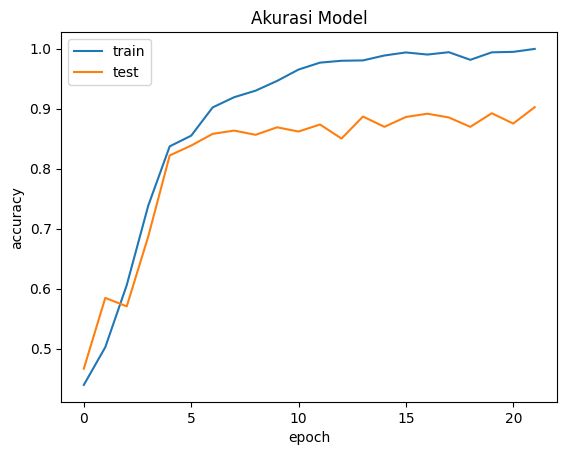

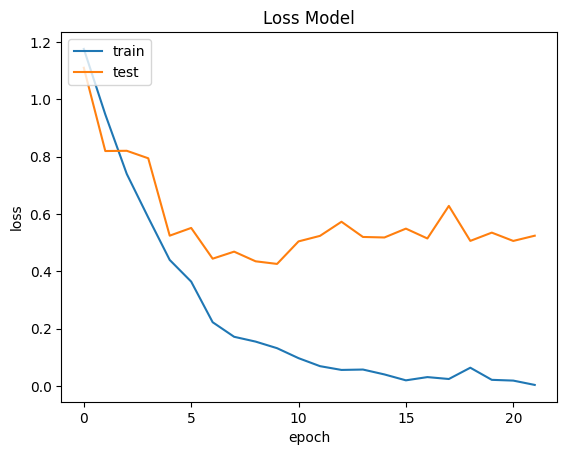

In [17]:
# Plot Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Plot Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
